In [1]:
import rnn, config
import torch
import numpy as np
import matplotlib.pyplot as plt
import vae_old as vae
import train_rnn_old as train_rnn
import train_vae_old as train_vae
import json

64.0 22 500

0.0 7(?) 500

In [3]:
random_index = 22
lambda_sv = 64.0
state_vars_to_predict = [9, 10, 11]
detach_gradients = False
use_layernorm = False
truncate_at_batch = 40
n_hidden = 128
train_epochs = 250
save_every_epochs = 50
max_gradient_norm = 100.0
lr = 0.001
random_index = random_index
lambda_sv = lambda_sv
dim_latent_z = 8
epoch = 500

sv_str = 'x'.join([str(x) for x in state_vars_to_predict]) if len(state_vars_to_predict) > 0 else 'X'
rnn_id = f"_ln{1 if use_layernorm else 0}_nh{n_hidden}_dlz{dim_latent_z}_mgn{max_gradient_norm}_lr{lr}" + \
         f"_dg{1 if detach_gradients else 0}_da{truncate_at_batch}_sv{sv_str}_lsv{lambda_sv}_r{random_index}"

vae_model = vae.VAE(latent_dim=dim_latent_z).to(config.device)
vae_model.load_state_dict(torch.load(f"data/vae_model_{dim_latent_z}dimlatent.pt", map_location=config.device))

rnn_model = rnn.MDNRNN(dim_latent_z, state_vars_to_predict=state_vars_to_predict, use_layernorm=use_layernorm).to(config.device)
rnn_model.load_state_dict(torch.load(f'data/rnn{rnn_id}/rnn_model_epoch{epoch}.pt', map_location=config.device))
n_gaussians = rnn_model.n_gaussians

In [4]:
batch_size = 256
length_cutoff = 301  # Specify the desired minimum length of episodes to consider

n_batches, mean_batches, var_batches, state_vars_batches, \
    action_batches, mask_batches, end_flag_batches = \
    train_rnn.load_data(f'data/vae_preprocessed_{dim_latent_z}dimlatent.npz', 
                                        f'data/vae_rollouts_env_vars.npz', batch_size = batch_size,
                       truncate_at_batch=truncate_at_batch)
episode_len = ([torch.nonzero(end_flags)[:, 1] for end_flags in end_flag_batches])

filtered_episodes = []
for i in range(len(episode_len)):
    for j in range(len(episode_len[i])):
        if episode_len[i][j] >= length_cutoff:
            episode_data = {
                'mean': mean_batches[i][j, :length_cutoff, :],
                'var': var_batches[i][j, :length_cutoff, :],
                'state_vars': state_vars_batches[i][j, :length_cutoff, :],
                'action': action_batches[i][j, :length_cutoff, :],
                'mask': mask_batches[i][j, :length_cutoff],
                'end_flag': end_flag_batches[i][j, :length_cutoff, :],
            }
            filtered_episodes.append(episode_data)
# Convert the filtered episodes to tensors
filtered_episodes_tensor = {
    'mean': torch.stack([ep['mean'] for ep in filtered_episodes]),
    'var': torch.stack([ep['var'] for ep in filtered_episodes]),
    'state_vars': torch.stack([ep['state_vars'] for ep in filtered_episodes]),
    'action': torch.stack([ep['action'] for ep in filtered_episodes]),
    'mask': torch.stack([ep['mask'] for ep in filtered_episodes]),
    'end_flag': torch.stack([ep['end_flag'] for ep in filtered_episodes])
} # shape of every tensor: [n_episodes, batch_size, dim_latent_z]
n_episodes = filtered_episodes_tensor['mean'].shape[0]
batch_size = n_episodes

In [5]:
def record_predictions(cutoff_t=None):
    """
        Runs the RNN over the selected episodes
        (optionally detaching from the environment at t=cutoff_t, 
        and continuing with the outputted Z values put back in).
        Returns the following:
        z_pred_store: (every entry is (pi, mu, sigma); each is [batch_size, 1, n_gaussians, :])
        ef_store: tensor of size [batch_size, n_timesteps, 1]
        y_store: tensor of size [batch_size, n_timesteps, RNN_hidden_dim]
    """
    means = filtered_episodes_tensor['mean']
    vars = filtered_episodes_tensor['var']
    actions = filtered_episodes_tensor['action']
    masks = filtered_episodes_tensor['mask'][:, 1:]
    state_vars = filtered_episodes_tensor['state_vars'][:, :-1]
    z_values = train_vae.reparameterization(means, vars)
    inputs = torch.cat([z_values, actions], dim=2)[:, :-1] #(batch_size, n_timesteps, dim_latent_z+1)
    n_timesteps = inputs.shape[1]
    if cutoff_t is None: cutoff_t = n_timesteps
    
    z_pred_store = [] # every entry is (pi, mu, sigma); each is [batch_size, 1, n_gaussians, :]
    ef_store = [] # each entry is [batch_size, 1, 1]
    y_store = [] # each entry is [batch_size, 1, 1]
    with torch.no_grad():
        hidden = rnn_model.init_hidden(batch_size)
        for t in range(n_timesteps):
            if t < cutoff_t:
                # sample true input from environment
                inputs_t = inputs[:, t:t+1, :]
            else:
                # sample input from previous output of RNN
                pi, mu, sigma = z_pred_store[-1]
                sampled_indices = torch.multinomial(pi[:, :, :].reshape(-1, n_gaussians), 1).reshape(batch_size, 1, 1, 1).repeat(1, 1, 1, dim_latent_z)
                mu_sampled = torch.gather(mu, 2, sampled_indices)
                sigma_sampled = torch.gather(sigma, 2, sampled_indices)
                z_sampled = train_vae.reparameterization(mu_sampled, sigma_sampled).reshape(batch_size, 1, dim_latent_z)
                inputs_t = torch.cat([z_sampled, actions[:, t:t+1, :]], dim=2)
                
            # run RNN on this input and record result
            (pi, mu, sigma), ef, hidden, y = rnn_model(inputs_t, hidden)
            z_pred_store.append((pi, mu, sigma))
            ef_store.append(ef)
            y_store.append(y)
    return z_pred_store, torch.cat(ef_store, dim=1), torch.cat(y_store, dim=1)

In [6]:
means = filtered_episodes_tensor['mean']
vars = filtered_episodes_tensor['var']
actions = filtered_episodes_tensor['action']
masks = filtered_episodes_tensor['mask'][:, 1:]
state_vars = filtered_episodes_tensor['state_vars'][:, :-1]
z_values = train_vae.reparameterization(means, vars)
inputs = torch.cat([z_values, actions], dim=2)[:, :-1]

In [7]:
def make_images(z_pred_store, episode_i):
    means = filtered_episodes_tensor['mean']
    vars = filtered_episodes_tensor['var']
    actions = filtered_episodes_tensor['action']
    masks = filtered_episodes_tensor['mask'][:, 1:]
    state_vars = filtered_episodes_tensor['state_vars'][:, :-1]
    z_values = train_vae.reparameterization(means, vars)
    inputs = torch.cat([z_values, actions], dim=2)[:, :-1]
    n_timesteps = inputs.shape[1]

    z_sampled_store = []
    for t in range(n_timesteps):
        # sample input from previous output of RNN
        pi, mu, sigma = z_pred_store[t]
        sampled_indices = torch.multinomial(pi[:, :, :].reshape(-1, n_gaussians), 1).reshape(batch_size, 1, 1, 1).repeat(1, 1, 1, dim_latent_z)
        mu_sampled = torch.gather(mu, 2, sampled_indices)
        sigma_sampled = torch.gather(sigma, 2, sampled_indices)
        z_sampled = train_vae.reparameterization(mu_sampled, sigma_sampled).reshape(batch_size, 1, dim_latent_z)
        z_sampled_store.append(z_sampled)

    z_sampled = torch.cat(z_sampled_store, dim=1)
    img_rec = vae_model.decode(z_sampled)[episode_i].cpu().detach().numpy()
    img_real = vae_model.decode(z_values[:, 1:])[episode_i].cpu().detach().numpy()
    return img_rec, img_real

In [31]:
cutoff_t = None
z_pred_store, ef_store, y_store = record_predictions(cutoff_t=cutoff_t)

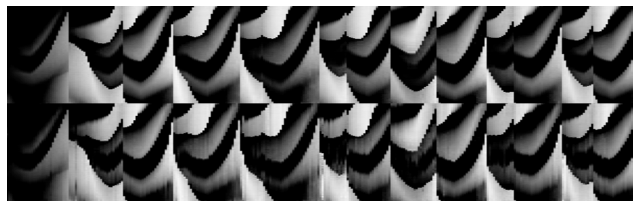

In [32]:
episode_i = 30
max_show_timestep = 300

img_rec, img_real = make_images(z_pred_store, episode_i)
img = np.concatenate([img_real[:max_show_timestep].T, img_rec[:max_show_timestep].T])
# Display the barcode tensor as an image using Matplotlib
plt.figure(figsize=(9, 3))  # Adjust the figure size as needed
plt.imshow(img, cmap='binary', aspect='auto')
if cutoff_t is not None:
    plt.plot([cutoff_t, cutoff_t], [-1000, 1000], "r--", linewidth=3)
plt.axis('off')
plt.ylim(360, 0)
plt.xlim(0, max_show_timestep)
plt.tight_layout()
plt.show()

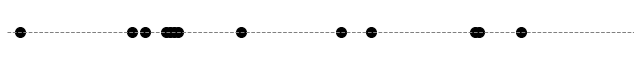

In [29]:
# show end flag over time
plt.figure(figsize=(9, 1))
actions_dots_y = 1-actions[episode_i, :max_show_timestep, 0].reshape(-1).detach().cpu().numpy()
actions_dots_x = np.arange(len(actions_dots_x))
plt.scatter(actions_dots_x, actions_dots_y, 100, color="black")
plt.plot([0, max_show_timestep], [0, 0], "--", color="gray", linewidth=1)
plt.plot([0, max_show_timestep], [1, 1], "--", color="gray", linewidth=1)
plt.ylim(-.1, 1.1)
plt.ylim(-.6, .6)
plt.xlim(0, max_show_timestep)
plt.axis('off')
plt.tight_layout()
plt.show()

In [65]:
def show_sv_curve(episode_i, sv_i, show_from=0, show_to=1, multiply_by=1, lines=[0, 1]):
    sv = state_vars[episode_i, :max_show_timestep, sv_i].reshape(-1).detach().cpu().numpy()
    
    print(config.state_variables_names[sv_i])
    plt.figure(figsize=(9, 1.5))
    plt.plot(sv*multiply_by, "-", color="black", linewidth=3)
    for line in lines:
        plt.plot([0, max_show_timestep], [line, line], "--", color="gray", linewidth=1)
    plt.ylim(-.1, 1.1)
    plt.ylim(show_from, show_to)
    plt.xlim(0, max_show_timestep)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

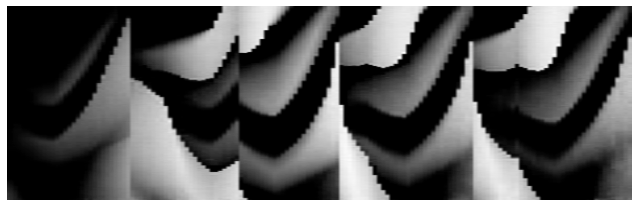

bird flap action


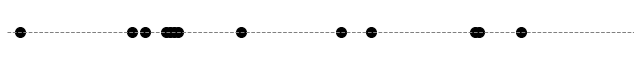

player's rotation


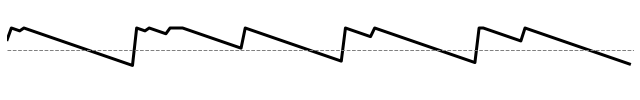

player's vertical velocity


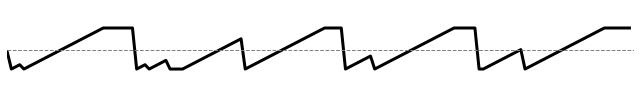

player's vertical position


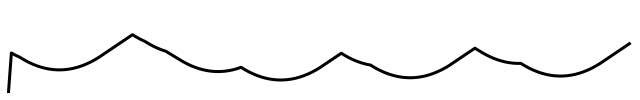

In [68]:
max_show_timestep = 150

img = np.concatenate([img_real[:max_show_timestep].T,])

# Display the barcode tensor as an image using Matplotlib
plt.figure(figsize=(9, 3))  # Adjust the figure size as needed
plt.imshow(img, cmap='binary', aspect='auto')
if cutoff_t is not None:
    plt.plot([cutoff_t, cutoff_t], [-1000, 1000], "r--", linewidth=3)
plt.axis('off')
plt.ylim(180, 0)
plt.xlim(0, max_show_timestep)
plt.tight_layout()
plt.show()

# show actions over time
print("bird flap action")
plt.figure(figsize=(9, 1))
actions_dots_y = 1-actions[episode_i, :max_show_timestep, 0].reshape(-1).detach().cpu().numpy()
actions_dots_x = np.arange(len(actions_dots_x))
plt.scatter(actions_dots_x, actions_dots_y, 100, color="black")
plt.plot([0, max_show_timestep], [0, 0], "--", color="gray", linewidth=1)
plt.plot([0, max_show_timestep], [1, 1], "--", color="gray", linewidth=1)
plt.ylim(-.1, 1.1)
plt.ylim(-.6, .6)
plt.xlim(0, max_show_timestep)
plt.axis('off')
plt.tight_layout()
plt.show()

# show end flag over time
show_sv_curve(episode_i, 11, show_from=-1, show_to=1, lines=[0])
show_sv_curve(episode_i, 10, show_from=-1, show_to=1, multiply_by=0.5, lines=[0])
show_sv_curve(episode_i, 9, show_from=.2, show_to=.8, lines=[])

In [ ]:
cutoff_t = None
z_pred_store, ef_store, y_store = record_predictions(cutoff_t=cutoff_t)

In [35]:
def show_sv_curve(sv_i, episode_i):
    decoder = best_decoders[sv_i]
    
    sv = state_vars[episode_i, :max_show_timestep, sv_i]
    
    print(config.state_variables_names[sv_i])
    plt.figure(figsize=(9, 2))
    plt.plot(state_vars[episode_i, :max_show_timestep, sv_i].reshape(-1).detach().cpu().numpy()/2,
            "-", color="black", linewidth=3)
    plt.plot([0, max_show_timestep], [0, 0], "--", color="gray", linewidth=1)
    plt.plot([0, max_show_timestep], [1, 1], "--", color="gray", linewidth=1)
    plt.ylim(-.1, 1.1)
    plt.ylim(-.6, .6)
    plt.xlim(0, max_show_timestep)
    plt.axis('off')
    plt.tight_layout()
    plt.show()